Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Jane Du"

---

In [2]:
# Import packages and define common functions. Do not modify.
import os
import numpy as np
import random
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

def show_and_save(img, file_name):
    """Show and save the image.
    Args:
        img (Tensor): The image.
        file_name (Str): The destination.
    """
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    plt.imshow(npimg, cmap='gray')
    plt.show()
    plt.imsave(f, npimg)

def train(model, train_loader, n_epochs=20, lr=0.01):
    """Train a generative model.
    Args:
        model: The model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.
    Returns:
        The trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_op = optim.Adam(model.parameters(), lr)
    model.train()
    model.to(device)
    for epoch in tqdm(range(n_epochs)):
        loss_ = []
        for _, (data, target) in enumerate(train_loader):
            loss = model.get_loss(data.view(-1, 784).to(device))
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()
        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(loss_)))
    return model

def train_vae2(model, train_loader, n_epochs=20, lr=0.01):
    """Train a generative model.
    Args:
        model: The model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.
    Returns:
        The trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_op = optim.Adam(model.parameters(), lr)
    model.train()
    model.to(device)
    for epoch in tqdm(range(n_epochs)):
        loss_ = []
        for _, (data, target) in enumerate(train_loader):
            loss = model.get_loss(data.to(device))
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()
        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(loss_)))
    return model

seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# RBM

In [ ]:
class RBM(nn.Module):
    """Restricted Boltzmann Machine.
    Args:
        n_vis (int, optional): The size of visible layer. Defaults to 784.
        n_hid (int, optional): The size of hidden layer. Defaults to 128.
        k (int, optional): The number of Gibbs sampling. Defaults to 1.
    """

    def __init__(self, n_vis=784, n_hid=128, k=1):
        """Create a RBM."""
        super(RBM, self).__init__()
        self.v = nn.Parameter(torch.randn(1, n_vis))
        self.h = nn.Parameter(torch.randn(1, n_hid))
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k

    def visible_to_hidden(self, v):
        r"""Conditional sampling a hidden variable given a visible variable.
        Args:
            v (Tensor): The visible variable.
        Returns:
            Tensor: The hidden variable.
        """
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        return p.bernoulli()

    def hidden_to_visible(self, h):
        r"""Conditional sampling a visible variable given a hidden variable.
        Args:
            h (Tendor): The hidden variable.
        Returns:
            Tensor: The visible variable.
        """
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return p.bernoulli()

    def free_energy(self, v, reduction="mean"):
        r"""Free energy function.
        .. math::
            \begin{align}
                F(x) &= -\log \sum_h \exp (-E(x, h)) \\
                &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
            \end{align}
        Args:
            v (Tensor): The visible variable.
        Returns:
            energy (FloatTensor): The free energy value.
        """
        energy = -F.linear(v, self.v).sum(-1)
        energy -= F.softplus(F.linear(v, self.W, self.h)).sum(-1)
        if reduction == "none":
            return energy.squeeze(-1)
        elif reduction == "mean":
            return torch.mean(energy)

    def forward(self, v):
        r"""Compute the real and generated examples.
        Args:
            v (Tensor): The visible variable.
        Returns:
            (Tensor, Tensor): The real and generated variables.
        """
        v_gibb = v.clone()
        for _ in range(self.k):
            h = self.visible_to_hidden(v_gibb)
            v_gibb = self.hidden_to_visible(h)
        return v, v_gibb

    def get_loss(self, inputs):
        r"""Compute the loss for training the model.
        Args:
            inputs (Tensor): The visible variable.
        Returns:
            Tensor: Loss.
        """
        v, v_gibb = self(inputs)
        # print(v.shape)
        # print(v_gibb.shape)
        # print(inputs.shape)
        loss = self.free_energy(v) - self.free_energy(v_gibb)
        return loss

    @torch.no_grad()
    def pseudo_likelihood(self, v):
        """DO NOT MODIFY THIS FUNCTION"""
        # Randomly corrupt one feature in each sample in v.
        ind = (np.arange(v.shape[0]), np.random.randint(0, v.shape[1], v.shape[0]))
        v_ = v.clone()
        v_[ind] = 1 - v_[ind]
        fe = self.free_energy(v, reduction="none")
        fe_ = self.free_energy(v_, reduction="none")
        m = torch.nn.LogSigmoid()
        score = v.shape[1] * m(fe_ - fe)
        return score

In [ ]:
# DO NOT MODIFY
train_dataset = datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), lambda x: (x > 0).float()]),
)
test_dataset = datasets.MNIST(
    "./data",
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), lambda x: (x > 0).float()]),
)

batch_size = 128
n_hid = 128
n_vis = 784
n_epochs = 20
lr = 0.01
rbm_ckpt_fn = "model_rbm_seed2025.pt"

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# You can try different k for the report, but use k=1 when submitting the checkpoint
# Do not modify other parts of this cell
if not os.path.exists(rbm_ckpt_fn):
    model_rbm = RBM(n_vis=n_vis, n_hid=n_hid, k=1)
    model_rbm = train(model_rbm, train_loader, n_epochs=n_epochs, lr=lr)
    # save model, do not change the filename.
    torch.save(model_rbm.state_dict(), rbm_ckpt_fn)

  5%|▌         | 1/20 [00:10<03:16, 10.32s/it]

Epoch 0	 Loss=104.6851


  5%|▌         | 1/20 [00:11<03:38, 11.50s/it]


KeyboardInterrupt: 

In [ ]:
# You can use the following code to visualize reconstructed samples
# model_rbm = RBM(n_vis=n_vis, n_hid=n_hid, k=25)
# model_rbm = train(model_rbm, train_loader, n_epochs=n_epochs, lr=lr)

model_rbm.eval()

vis_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

images = next(iter(vis_loader))[0]

v, v_gibbs = model_rbm(images.view(-1, 784))

show_and_save(make_grid(v_gibbs.view(64, 1, 28, 28).data), "rbm_fake")

  5%|▌         | 1/20 [00:30<09:35, 30.30s/it]

Epoch 0	 Loss=144.4315


  5%|▌         | 1/20 [00:54<17:14, 54.46s/it]


KeyboardInterrupt: 

# VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        # Encoder
        self.enc_lin = nn.Linear(input_dim, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim)
        self.enc_sigma = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.dec_lin1 = nn.Linear(latent_dim, hidden_dim)
        self.dec_lin2 = nn.Linear(hidden_dim, input_dim)

    def encoding(self, x):
        """Encode inputs x.
        Args:
            x (Tensor): Inputs. Take Tanh as the enc_lin layer's non-linear activation function.
        Returns:
            (z_mu, z_sigma): Mean and log variance of latent variables z.
        """
        # YOUR CODE HERE
        z_mu = self.enc_mu(torch.tanh(self.enc_lin(x)))
        z_sigma = self.enc_sigma(torch.tanh(self.enc_lin(x)))
        return z_mu, z_sigma

    def decoding(self, z):
        """Decode latent variable z into reconstructed data.
        Two linear layers with Tanh as the middle layer's act func and Sigmoid as the output layer's act func.
        Args:
            z (Tensor): Inputs.
        Returns:
            x_hat: Reconstructed inputs.
        """
        # YOUR CODE HERE
        z = torch.tanh(self.dec_lin1(z))
        z = F.sigmoid(self.dec_lin2(z))
        return z

    def forward(self, x):
        """Compute reconstructed inputs.
        Args:
            x (Tensor): Inputs.
        Returns:
            (x_hat, z_mu, z_sigma): Reconstructed inputs, mean and log variance of latent variables.
        """
        # YOUR CODE HERE
        z_mu, z_sigma = self.encoding(x)
        z = z_mu + torch.randn_like(z_sigma) * torch.exp(0.5 * z_sigma)
        x_hat = self.decoding(z)
        return x_hat, z_mu, z_sigma

    def get_loss(self, x):
        """Compute VAE loss.
        Args:
            x (Tensor): Inputs.
        Returns:
            loss (FloatTensor): reconstruction loss + KL loss
        """
        x_hat, z_mu, z_sigma = self(x)
        reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + z_sigma - z_mu.pow(2) - torch.exp(z_sigma))
        return reconstruction_loss + kl_loss

    @torch.no_grad()
    def sample(self, n_samples, device):
        random_z = torch.randn(n_samples, self.latent_dim).to(device)
        self.to(device)
        x_hat = self.decoding(random_z)
        return x_hat

In [ ]:
# DO NOT MODIFY
train_dataset = datasets.MNIST(
    "./data", train=True, transform=transforms.Compose([transforms.ToTensor()])
)
test_dataset = datasets.MNIST(
    "./data", train=False, transform=transforms.Compose([transforms.ToTensor()])
)

batch_size = 128
input_dim = 784
hidden_dim = 500
n_epochs = 40
lr = 0.001
vae_ckpt_fn = "log/VAE/reference/model_vae_seed2025.pt"

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# # You can try different latent_dim for the report, but use latent_dim=20 when submitting the checkpoint
# # Do not modify other parts of this cell
model_vae = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=20)
model_vae = train(model_vae, train_loader, n_epochs=n_epochs, lr=lr)
# save model, do not change the filename.
torch.save(model_vae.state_dict(), vae_ckpt_fn)

  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:08<05:39,  8.72s/it]

Epoch 0	 Loss=5743.8718


  5%|▌         | 2/40 [00:17<05:30,  8.70s/it]

Epoch 1	 Loss=4686.9854


  8%|▊         | 3/40 [00:27<05:50,  9.46s/it]

Epoch 2	 Loss=4529.8804


 10%|█         | 4/40 [00:38<05:57,  9.94s/it]

Epoch 3	 Loss=4397.9274


 12%|█▎        | 5/40 [00:49<06:03, 10.38s/it]

Epoch 4	 Loss=4268.6930


 15%|█▌        | 6/40 [01:00<06:04, 10.72s/it]

Epoch 5	 Loss=4179.2472


 18%|█▊        | 7/40 [01:10<05:41, 10.35s/it]

Epoch 6	 Loss=4114.1032


 20%|██        | 8/40 [01:20<05:24, 10.14s/it]

Epoch 7	 Loss=4062.2207


 22%|██▎       | 9/40 [01:30<05:10, 10.01s/it]

Epoch 8	 Loss=4025.1998


 25%|██▌       | 10/40 [01:41<05:10, 10.36s/it]

Epoch 9	 Loss=3993.9177


 28%|██▊       | 11/40 [01:51<05:03, 10.47s/it]

Epoch 10	 Loss=3964.0041


 30%|███       | 12/40 [02:01<04:47, 10.25s/it]

Epoch 11	 Loss=3943.2873


 32%|███▎      | 13/40 [02:11<04:30, 10.02s/it]

Epoch 12	 Loss=3921.9663


 35%|███▌      | 14/40 [02:20<04:19,  9.96s/it]

Epoch 13	 Loss=3908.7290


 38%|███▊      | 15/40 [02:31<04:11, 10.05s/it]

Epoch 14	 Loss=3886.9992


 40%|████      | 16/40 [02:43<04:14, 10.58s/it]

Epoch 15	 Loss=3877.3633


 42%|████▎     | 17/40 [02:54<04:07, 10.78s/it]

Epoch 16	 Loss=3862.7961


 45%|████▌     | 18/40 [03:04<03:53, 10.59s/it]

Epoch 17	 Loss=3851.1339


 48%|████▊     | 19/40 [03:14<03:37, 10.36s/it]

Epoch 18	 Loss=3843.5072


 50%|█████     | 20/40 [03:24<03:28, 10.42s/it]

Epoch 19	 Loss=3832.3427


 52%|█████▎    | 21/40 [03:35<03:19, 10.50s/it]

Epoch 20	 Loss=3823.5512


 55%|█████▌    | 22/40 [03:46<03:10, 10.57s/it]

Epoch 21	 Loss=3815.9093


 57%|█████▊    | 23/40 [03:56<03:00, 10.62s/it]

Epoch 22	 Loss=3807.5751


 60%|██████    | 24/40 [04:07<02:49, 10.58s/it]

Epoch 23	 Loss=3799.2979


 62%|██████▎   | 25/40 [04:18<02:39, 10.62s/it]

Epoch 24	 Loss=3788.7459


 65%|██████▌   | 26/40 [04:28<02:27, 10.54s/it]

Epoch 25	 Loss=3785.4812


 68%|██████▊   | 27/40 [04:40<02:21, 10.92s/it]

Epoch 26	 Loss=3776.1438


 70%|███████   | 28/40 [04:51<02:10, 10.90s/it]

Epoch 27	 Loss=3773.7672


 72%|███████▎  | 29/40 [05:02<02:00, 10.96s/it]

Epoch 28	 Loss=3766.2697


 75%|███████▌  | 30/40 [05:13<01:49, 10.94s/it]

Epoch 29	 Loss=3760.3253


 78%|███████▊  | 31/40 [05:23<01:37, 10.78s/it]

Epoch 30	 Loss=3755.2307


 80%|████████  | 32/40 [05:34<01:25, 10.74s/it]

Epoch 31	 Loss=3751.0771


 82%|████████▎ | 33/40 [05:45<01:15, 10.84s/it]

Epoch 32	 Loss=3748.1432


 85%|████████▌ | 34/40 [05:55<01:03, 10.65s/it]

Epoch 33	 Loss=3745.1323


 88%|████████▊ | 35/40 [06:06<00:53, 10.75s/it]

Epoch 34	 Loss=3738.8653


 90%|█████████ | 36/40 [06:16<00:41, 10.45s/it]

Epoch 35	 Loss=3736.2381


 92%|█████████▎| 37/40 [06:25<00:30, 10.24s/it]

Epoch 36	 Loss=3731.8226


 95%|█████████▌| 38/40 [06:37<00:21, 10.59s/it]

Epoch 37	 Loss=3728.5273


 98%|█████████▊| 39/40 [06:49<00:10, 10.91s/it]

Epoch 38	 Loss=3724.2201


100%|██████████| 40/40 [06:59<00:00, 10.49s/it]

Epoch 39	 Loss=3719.8458


  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:10<07:08, 11.00s/it]

Epoch 0	 Loss=6279.1350


  5%|▌         | 2/40 [00:21<06:47, 10.71s/it]

Epoch 1	 Loss=5630.1463


  8%|▊         | 3/40 [00:32<06:33, 10.64s/it]

Epoch 2	 Loss=5429.1021


 10%|█         | 4/40 [00:42<06:19, 10.54s/it]

Epoch 3	 Loss=5302.6091


 12%|█▎        | 5/40 [00:52<06:07, 10.49s/it]

Epoch 4	 Loss=5213.4692


 15%|█▌        | 6/40 [01:03<05:56, 10.49s/it]

Epoch 5	 Loss=5152.9392


 18%|█▊        | 7/40 [01:13<05:40, 10.32s/it]

Epoch 6	 Loss=5106.8394


 20%|██        | 8/40 [01:24<05:36, 10.50s/it]

Epoch 7	 Loss=5064.5880


 22%|██▎       | 9/40 [01:35<05:36, 10.84s/it]

Epoch 8	 Loss=5033.7444


 25%|██▌       | 10/40 [01:46<05:22, 10.76s/it]

Epoch 9	 Loss=5008.8821


 28%|██▊       | 11/40 [01:57<05:12, 10.77s/it]

Epoch 10	 Loss=4984.6636


 30%|███       | 12/40 [02:07<05:01, 10.78s/it]

Epoch 11	 Loss=4963.0003


 32%|███▎      | 13/40 [02:18<04:51, 10.78s/it]

Epoch 12	 Loss=4942.2939


 35%|███▌      | 14/40 [02:30<04:44, 10.93s/it]

Epoch 13	 Loss=4920.8264


 38%|███▊      | 15/40 [02:41<04:35, 11.02s/it]

Epoch 14	 Loss=4903.8104


 40%|████      | 16/40 [02:51<04:18, 10.78s/it]

Epoch 15	 Loss=4889.1578


 42%|████▎     | 17/40 [03:01<04:05, 10.68s/it]

Epoch 16	 Loss=4878.5942


 45%|████▌     | 18/40 [03:12<03:54, 10.66s/it]

Epoch 17	 Loss=4860.6796


 48%|████▊     | 19/40 [03:22<03:42, 10.58s/it]

Epoch 18	 Loss=4852.5402


 50%|█████     | 20/40 [03:34<03:35, 10.78s/it]

Epoch 19	 Loss=4844.2518


 52%|█████▎    | 21/40 [03:45<03:28, 10.98s/it]

Epoch 20	 Loss=4828.6337


 55%|█████▌    | 22/40 [03:56<03:14, 10.81s/it]

Epoch 21	 Loss=4817.6732


 57%|█████▊    | 23/40 [04:06<03:01, 10.65s/it]

Epoch 22	 Loss=4810.4585


 60%|██████    | 24/40 [04:16<02:47, 10.48s/it]

Epoch 23	 Loss=4802.0899


 62%|██████▎   | 25/40 [04:27<02:38, 10.54s/it]

Epoch 24	 Loss=4792.3648


 65%|██████▌   | 26/40 [04:39<02:33, 10.96s/it]

Epoch 25	 Loss=4782.1327


 68%|██████▊   | 27/40 [04:49<02:19, 10.72s/it]

Epoch 26	 Loss=4774.6716


 70%|███████   | 28/40 [05:00<02:09, 10.81s/it]

Epoch 27	 Loss=4771.2068


 72%|███████▎  | 29/40 [05:10<01:58, 10.80s/it]

Epoch 28	 Loss=4763.0656


 75%|███████▌  | 30/40 [05:21<01:46, 10.64s/it]

Epoch 29	 Loss=4753.3029


 78%|███████▊  | 31/40 [05:32<01:37, 10.79s/it]

Epoch 30	 Loss=4748.9087


 80%|████████  | 32/40 [05:44<01:28, 11.05s/it]

Epoch 31	 Loss=4740.3594


 82%|████████▎ | 33/40 [05:55<01:18, 11.26s/it]

Epoch 32	 Loss=4730.8108


 85%|████████▌ | 34/40 [06:07<01:09, 11.52s/it]

Epoch 33	 Loss=4727.3831


 88%|████████▊ | 35/40 [06:19<00:57, 11.54s/it]

Epoch 34	 Loss=4719.0522


 90%|█████████ | 36/40 [06:31<00:46, 11.56s/it]

Epoch 35	 Loss=4715.6202


 92%|█████████▎| 37/40 [06:43<00:35, 11.95s/it]

Epoch 36	 Loss=4711.3230


 95%|█████████▌| 38/40 [06:56<00:24, 12.12s/it]

Epoch 37	 Loss=4705.6067


 98%|█████████▊| 39/40 [07:08<00:12, 12.05s/it]

Epoch 38	 Loss=4697.9781


100%|██████████| 40/40 [07:19<00:00, 10.99s/it]

Epoch 39	 Loss=4696.9024


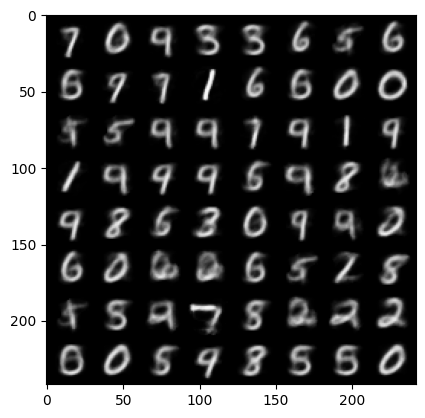

  2%|▎         | 1/40 [00:12<07:53, 12.15s/it]

Epoch 0	 Loss=6299.1509


  5%|▌         | 2/40 [00:25<08:17, 13.10s/it]

Epoch 1	 Loss=5599.6144


  8%|▊         | 3/40 [00:38<07:48, 12.65s/it]

Epoch 2	 Loss=5395.9143


 10%|█         | 4/40 [00:49<07:22, 12.28s/it]

Epoch 3	 Loss=5298.6128


 12%|█▎        | 5/40 [01:01<07:07, 12.21s/it]

Epoch 4	 Loss=5222.5180


 15%|█▌        | 6/40 [01:13<06:47, 11.98s/it]

Epoch 5	 Loss=5151.7889


 18%|█▊        | 7/40 [01:25<06:35, 11.99s/it]

Epoch 6	 Loss=5094.5359


 20%|██        | 8/40 [01:37<06:22, 11.95s/it]

Epoch 7	 Loss=5040.2768


 22%|██▎       | 9/40 [01:49<06:11, 11.97s/it]

Epoch 8	 Loss=4996.6052


 25%|██▌       | 10/40 [02:01<05:58, 11.95s/it]

Epoch 9	 Loss=4965.8672


 28%|██▊       | 11/40 [02:15<06:10, 12.76s/it]

Epoch 10	 Loss=4932.2548


 30%|███       | 12/40 [02:27<05:45, 12.33s/it]

Epoch 11	 Loss=4906.4834


 32%|███▎      | 13/40 [02:36<05:09, 11.45s/it]

Epoch 12	 Loss=4887.6552


 35%|███▌      | 14/40 [02:47<04:50, 11.16s/it]

Epoch 13	 Loss=4871.9601


 38%|███▊      | 15/40 [02:57<04:31, 10.87s/it]

Epoch 14	 Loss=4851.2629


 40%|████      | 16/40 [03:10<04:36, 11.52s/it]

Epoch 15	 Loss=4834.6091


 42%|████▎     | 17/40 [03:35<06:03, 15.79s/it]

Epoch 16	 Loss=4821.7200


 45%|████▌     | 18/40 [03:52<05:53, 16.05s/it]

Epoch 17	 Loss=4809.7458


 48%|████▊     | 19/40 [04:09<05:40, 16.23s/it]

Epoch 18	 Loss=4798.0173


 50%|█████     | 20/40 [04:20<04:57, 14.86s/it]

Epoch 19	 Loss=4786.2790


 52%|█████▎    | 21/40 [04:32<04:25, 13.99s/it]

Epoch 20	 Loss=4771.3617


 55%|█████▌    | 22/40 [04:47<04:16, 14.23s/it]

Epoch 21	 Loss=4764.0157


 57%|█████▊    | 23/40 [04:59<03:49, 13.53s/it]

Epoch 22	 Loss=4760.7747


 60%|██████    | 24/40 [05:09<03:18, 12.42s/it]

Epoch 23	 Loss=4746.2204


 62%|██████▎   | 25/40 [05:19<02:57, 11.84s/it]

Epoch 24	 Loss=4740.8332


 65%|██████▌   | 26/40 [05:30<02:39, 11.37s/it]

Epoch 25	 Loss=4732.3389


 68%|██████▊   | 27/40 [05:39<02:20, 10.84s/it]

Epoch 26	 Loss=4724.8390


 70%|███████   | 28/40 [05:49<02:06, 10.52s/it]

Epoch 27	 Loss=4713.4512


 72%|███████▎  | 29/40 [06:02<02:03, 11.21s/it]

Epoch 28	 Loss=4707.7562


 75%|███████▌  | 30/40 [06:13<01:51, 11.17s/it]

Epoch 29	 Loss=4702.4193


 78%|███████▊  | 31/40 [06:22<01:35, 10.58s/it]

Epoch 30	 Loss=4695.2759


 80%|████████  | 32/40 [06:32<01:22, 10.36s/it]

Epoch 31	 Loss=4689.5259


 82%|████████▎ | 33/40 [06:42<01:11, 10.25s/it]

Epoch 32	 Loss=4680.5339


 85%|████████▌ | 34/40 [06:51<00:58,  9.83s/it]

Epoch 33	 Loss=4673.4967


 88%|████████▊ | 35/40 [06:59<00:47,  9.48s/it]

Epoch 34	 Loss=4669.4134


 90%|█████████ | 36/40 [07:10<00:38,  9.68s/it]

Epoch 35	 Loss=4662.5464


 92%|█████████▎| 37/40 [07:19<00:28,  9.64s/it]

Epoch 36	 Loss=4654.3160


 95%|█████████▌| 38/40 [07:28<00:18,  9.30s/it]

Epoch 37	 Loss=4648.1433


 98%|█████████▊| 39/40 [07:36<00:09,  9.05s/it]

Epoch 38	 Loss=4646.0965


100%|██████████| 40/40 [07:45<00:00, 11.63s/it]

Epoch 39	 Loss=4640.0104


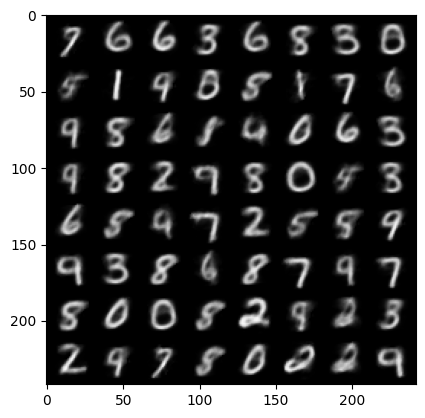

  2%|▎         | 1/40 [00:08<05:30,  8.48s/it]

Epoch 0	 Loss=6271.7653


  5%|▌         | 2/40 [00:16<05:21,  8.45s/it]

Epoch 1	 Loss=5655.7092


  8%|▊         | 3/40 [00:25<05:11,  8.42s/it]

Epoch 2	 Loss=5472.7420


 10%|█         | 4/40 [00:34<05:21,  8.92s/it]

Epoch 3	 Loss=5353.0207


 12%|█▎        | 5/40 [00:43<05:07,  8.80s/it]

Epoch 4	 Loss=5258.0259


 15%|█▌        | 6/40 [00:51<04:54,  8.66s/it]

Epoch 5	 Loss=5185.4370


 18%|█▊        | 7/40 [01:00<04:43,  8.58s/it]

Epoch 6	 Loss=5127.2513


 20%|██        | 8/40 [01:08<04:32,  8.53s/it]

Epoch 7	 Loss=5081.8328


 22%|██▎       | 9/40 [01:17<04:23,  8.49s/it]

Epoch 8	 Loss=5039.4526


 25%|██▌       | 10/40 [01:25<04:14,  8.48s/it]

Epoch 9	 Loss=5010.8973


 28%|██▊       | 11/40 [01:35<04:14,  8.79s/it]

Epoch 10	 Loss=4982.9351


 30%|███       | 12/40 [01:43<04:03,  8.68s/it]

Epoch 11	 Loss=4958.4075


 32%|███▎      | 13/40 [01:51<03:52,  8.59s/it]

Epoch 12	 Loss=4936.6783


 35%|███▌      | 14/40 [02:00<03:44,  8.64s/it]

Epoch 13	 Loss=4921.6897


 38%|███▊      | 15/40 [02:09<03:33,  8.56s/it]

Epoch 14	 Loss=4901.3928


 40%|████      | 16/40 [02:17<03:26,  8.59s/it]

Epoch 15	 Loss=4889.6424


 42%|████▎     | 17/40 [02:26<03:16,  8.52s/it]

Epoch 16	 Loss=4875.4159


 45%|████▌     | 18/40 [02:35<03:12,  8.76s/it]

Epoch 17	 Loss=4861.9208


 48%|████▊     | 19/40 [02:44<03:03,  8.73s/it]

Epoch 18	 Loss=4845.4988


 50%|█████     | 20/40 [02:52<02:52,  8.64s/it]

Epoch 19	 Loss=4834.6388


 52%|█████▎    | 21/40 [03:01<02:43,  8.61s/it]

Epoch 20	 Loss=4822.4634


 55%|█████▌    | 22/40 [03:09<02:33,  8.55s/it]

Epoch 21	 Loss=4815.9828


 57%|█████▊    | 23/40 [03:17<02:24,  8.51s/it]

Epoch 22	 Loss=4799.4231


 60%|██████    | 24/40 [03:26<02:18,  8.66s/it]

Epoch 23	 Loss=4791.4433


 62%|██████▎   | 25/40 [03:36<02:12,  8.83s/it]

Epoch 24	 Loss=4781.9348


 65%|██████▌   | 26/40 [03:44<02:03,  8.80s/it]

Epoch 25	 Loss=4775.3345


 68%|██████▊   | 27/40 [03:54<01:58,  9.12s/it]

Epoch 26	 Loss=4766.8978


 70%|███████   | 28/40 [04:03<01:47,  8.93s/it]

Epoch 27	 Loss=4755.8401


 72%|███████▎  | 29/40 [04:11<01:36,  8.76s/it]

Epoch 28	 Loss=4752.9662


 75%|███████▌  | 30/40 [04:19<01:26,  8.65s/it]

Epoch 29	 Loss=4740.8589


 78%|███████▊  | 31/40 [04:28<01:17,  8.58s/it]

Epoch 30	 Loss=4738.2330


 80%|████████  | 32/40 [04:38<01:11,  8.92s/it]

Epoch 31	 Loss=4728.1864


 82%|████████▎ | 33/40 [04:47<01:02,  8.94s/it]

Epoch 32	 Loss=4723.6956


 85%|████████▌ | 34/40 [04:55<00:53,  8.85s/it]

Epoch 33	 Loss=4717.3206


 88%|████████▊ | 35/40 [05:04<00:43,  8.71s/it]

Epoch 34	 Loss=4709.4251


 90%|█████████ | 36/40 [05:12<00:34,  8.62s/it]

Epoch 35	 Loss=4703.8971


 92%|█████████▎| 37/40 [05:20<00:25,  8.56s/it]

Epoch 36	 Loss=4698.2127


 95%|█████████▌| 38/40 [05:29<00:17,  8.55s/it]

Epoch 37	 Loss=4697.5289


 98%|█████████▊| 39/40 [05:38<00:08,  8.72s/it]

Epoch 38	 Loss=4687.8541


100%|██████████| 40/40 [05:46<00:00,  8.67s/it]

Epoch 39	 Loss=4685.2550


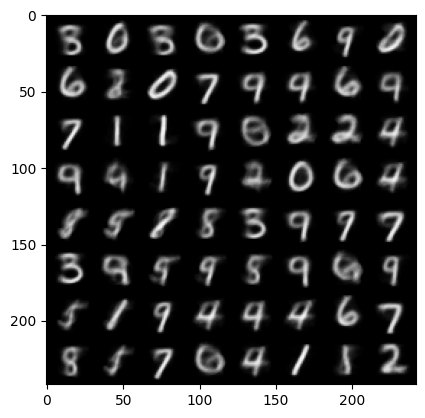

  2%|▎         | 1/40 [00:08<05:28,  8.43s/it]

Epoch 0	 Loss=6161.1791


  5%|▌         | 2/40 [00:16<05:23,  8.51s/it]

Epoch 1	 Loss=5500.4156


  8%|▊         | 3/40 [00:25<05:12,  8.45s/it]

Epoch 2	 Loss=5320.0323


 10%|█         | 4/40 [00:34<05:06,  8.53s/it]

Epoch 3	 Loss=5225.0705


 12%|█▎        | 5/40 [00:42<04:56,  8.49s/it]

Epoch 4	 Loss=5153.5226


 15%|█▌        | 6/40 [00:50<04:47,  8.44s/it]

Epoch 5	 Loss=5102.9904


 18%|█▊        | 7/40 [00:59<04:37,  8.42s/it]

Epoch 6	 Loss=5060.0484


 20%|██        | 8/40 [01:07<04:31,  8.48s/it]

Epoch 7	 Loss=5023.1027


 22%|██▎       | 9/40 [01:16<04:23,  8.51s/it]

Epoch 8	 Loss=4988.3972


 25%|██▌       | 10/40 [01:24<04:16,  8.54s/it]

Epoch 9	 Loss=4961.9659


 28%|██▊       | 11/40 [01:34<04:13,  8.74s/it]

Epoch 10	 Loss=4936.0376


 30%|███       | 12/40 [01:43<04:07,  8.84s/it]

Epoch 11	 Loss=4913.0683


 32%|███▎      | 13/40 [01:51<03:54,  8.70s/it]

Epoch 12	 Loss=4889.9967


 35%|███▌      | 14/40 [01:59<03:43,  8.60s/it]

Epoch 13	 Loss=4873.4050


 38%|███▊      | 15/40 [02:08<03:32,  8.50s/it]

Epoch 14	 Loss=4855.9316


 40%|████      | 16/40 [02:16<03:23,  8.48s/it]

Epoch 15	 Loss=4839.4254


 42%|████▎     | 17/40 [02:25<03:14,  8.48s/it]

Epoch 16	 Loss=4823.7991


 45%|████▌     | 18/40 [02:33<03:05,  8.43s/it]

Epoch 17	 Loss=4806.2569


 48%|████▊     | 19/40 [02:41<02:56,  8.41s/it]

Epoch 18	 Loss=4794.2505


 50%|█████     | 20/40 [02:50<02:48,  8.40s/it]

Epoch 19	 Loss=4780.8025


 52%|█████▎    | 21/40 [02:58<02:39,  8.38s/it]

Epoch 20	 Loss=4769.7116


 55%|█████▌    | 22/40 [03:06<02:30,  8.38s/it]

Epoch 21	 Loss=4758.5019


 57%|█████▊    | 23/40 [03:15<02:22,  8.35s/it]

Epoch 22	 Loss=4746.0904


 60%|██████    | 24/40 [03:23<02:13,  8.36s/it]

Epoch 23	 Loss=4736.8209


 62%|██████▎   | 25/40 [03:32<02:06,  8.43s/it]

Epoch 24	 Loss=4727.5386


 65%|██████▌   | 26/40 [03:40<01:57,  8.41s/it]

Epoch 25	 Loss=4718.4971


 68%|██████▊   | 27/40 [03:49<01:52,  8.68s/it]

Epoch 26	 Loss=4710.2748


 70%|███████   | 28/40 [03:58<01:42,  8.57s/it]

Epoch 27	 Loss=4699.9832


 72%|███████▎  | 29/40 [04:06<01:33,  8.50s/it]

Epoch 28	 Loss=4693.8854


 75%|███████▌  | 30/40 [04:14<01:24,  8.45s/it]

Epoch 29	 Loss=4685.4006


 78%|███████▊  | 31/40 [04:23<01:15,  8.43s/it]

Epoch 30	 Loss=4678.5421


 80%|████████  | 32/40 [04:31<01:07,  8.40s/it]

Epoch 31	 Loss=4670.3840


 82%|████████▎ | 33/40 [04:40<00:59,  8.44s/it]

Epoch 32	 Loss=4665.1864


 85%|████████▌ | 34/40 [04:49<00:52,  8.69s/it]

Epoch 33	 Loss=4658.1918


 88%|████████▊ | 35/40 [04:57<00:42,  8.58s/it]

Epoch 34	 Loss=4650.0757


 90%|█████████ | 36/40 [05:06<00:34,  8.50s/it]

Epoch 35	 Loss=4641.3119


 92%|█████████▎| 37/40 [05:14<00:25,  8.44s/it]

Epoch 36	 Loss=4638.8779


 95%|█████████▌| 38/40 [05:22<00:16,  8.42s/it]

Epoch 37	 Loss=4635.0533


 98%|█████████▊| 39/40 [05:30<00:08,  8.37s/it]

Epoch 38	 Loss=4626.1827


100%|██████████| 40/40 [05:39<00:00,  8.48s/it]

Epoch 39	 Loss=4622.0612


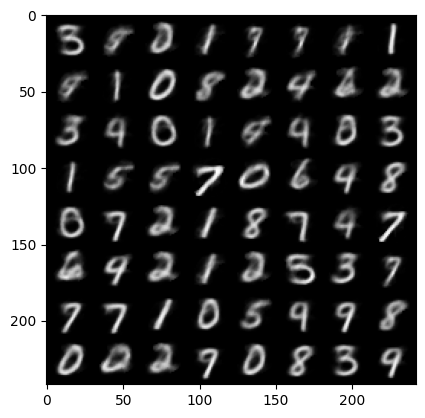

In [ ]:
n_epochs = 40
for latent_dim in [2,5,10,20]:
    model_vae = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=2)
    model_vae = train(model_vae, train_loader, n_epochs=n_epochs, lr=lr)
    # You can use the following code to visualize generated samples

    model_vae.eval()
    x_hat = model_vae.sample(64, "cpu")
    # x_hat = x_hat.bernoulli()
    show_and_save(make_grid(x_hat.view(64, 1, 28, 28).data.cpu()), f"log/VAE/reference/vae_fake_{latent_dim}")

# VAE2

In [7]:
import torch
import torch.nn as nn

class VAE2(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encd = 8 * 3 * 3
        self.decd = 8 * 3 * 3

        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.enc_mu = nn.Linear(self.encd, self.latent_dim)
        self.enc_sigma = nn.Linear(self.encd, self.latent_dim)

        self.dec_fc = nn.Linear(self.latent_dim, self.decd)
        self.deconv1 = nn.ConvTranspose2d(8, 8, 2, stride=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d( 8, 8,2,stride=2, )
        self.deconv3 = nn.ConvTranspose2d(
            8,
            8,
            2,
            stride=2,
        )
        self.dec_conv = nn.Conv2d(8, 1, 3, padding=1)

    def encoding(self, x):
        """Encode inputs x.
        Args:
            x (Tensor): Inputs. Take Tanh as the enc_lin layer's non-linear activation function.
        Returns:
            (z_mu, z_sigma): Mean and log variance of latent variables z.
        """
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        z_mu = self.enc_mu(x.view(-1, self.encd))
        z_sigma = self.enc_sigma(x.view(-1, self.encd))
        return z_mu, z_sigma

    def decoding(self, z):
        """Decode latent variable z into reconstructed data.
        Two linear layers with Tanh as the middle layer's act func and Sigmoid as the output layer's act func.
        Args:
            z (Tensor): Inputs.
        Returns:
            x_hat: Reconstructed inputs.
        """
        z = self.dec_fc(z).view(-1, 8, 3, 3)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        x_hat = torch.sigmoid(self.dec_conv(z))

        return x_hat

    def forward(self, x):
        """Compute reconstructed inputs.
        Args:
            x (Tensor): Inputs.
        Returns:
            (x_hat, z_mu, z_sigma): Reconstructed inputs, mean and log variance of latent variables.
        """
        # YOUR CODE HERE
        z_mu, z_sigma = self.encoding(x)
        z = z_mu + torch.randn_like(z_sigma) * torch.exp(0.5 * z_sigma)
        x_hat = self.decoding(z)
        return x_hat, z_mu, z_sigma

    def get_loss(self, x):
        """Compute VAE loss.
        Args:
            x (Tensor): Inputs.
        Returns:
            loss (FloatTensor): reconstruction loss + KL loss
        """
        x_hat, z_mu, z_sigma = self(x)
        reconstruction_loss = F.mse_loss(x_hat, x, reduction="sum")
        kl_loss = -0.5 * torch.sum(1 + z_sigma - z_mu.pow(2) - torch.exp(z_sigma))
        return reconstruction_loss + 0.05 * kl_loss

    @torch.no_grad()
    def sample(self, n_samples, device):
        random_z = torch.randn(n_samples, self.latent_dim).to(device)
        self.to(device)
        x_hat = self.decoding(random_z)
        return x_hat

In [8]:
# DO NOT MODIFY
train_dataset = datasets.MNIST(
    "./data", train=True, transform=transforms.Compose([transforms.ToTensor()])
)
test_dataset = datasets.MNIST(
    "./data", train=False, transform=transforms.Compose([transforms.ToTensor()])
)

batch_size = 128
n_epochs = 40
lr = 0.005
vae_ckpt_fn = "log/VAE/reference/model_vae2_seed2025.pt"

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# You can try different latent_dim for the report, but use latent_dim=20 when submitting the checkpoint
# Do not modify other parts of this cell
# if not os.path.exists(vae_ckpt_fn):
model_vae = VAE2(latent_dim=20)
model_vae = train_vae2(model_vae, train_loader, n_epochs=n_epochs, lr=lr)
# save model, do not change the filename.
torch.save(model_vae.state_dict(), vae_ckpt_fn)

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0	 Loss=5873.0273
Epoch 1	 Loss=2833.8332
Epoch 2	 Loss=2410.7136
Epoch 3	 Loss=2266.7829
Epoch 4	 Loss=2190.6970
Epoch 5	 Loss=2144.4240
Epoch 6	 Loss=2100.8715
Epoch 7	 Loss=2076.8856
Epoch 8	 Loss=2055.9895
Epoch 9	 Loss=2036.0579
Epoch 10	 Loss=2022.6913
Epoch 11	 Loss=2010.8788
Epoch 12	 Loss=2000.1412
Epoch 13	 Loss=1988.6673
Epoch 14	 Loss=1983.4563
Epoch 15	 Loss=1977.5129
Epoch 16	 Loss=1969.8762
Epoch 17	 Loss=1964.6060
Epoch 18	 Loss=1956.4247
Epoch 19	 Loss=1947.9584
Epoch 20	 Loss=1946.1971
Epoch 21	 Loss=1938.9819
Epoch 22	 Loss=1935.2974
Epoch 23	 Loss=1932.0805
Epoch 24	 Loss=1929.6813
Epoch 25	 Loss=1926.2563
Epoch 26	 Loss=1917.4165
Epoch 27	 Loss=1918.6671
Epoch 28	 Loss=1911.8117
Epoch 29	 Loss=1908.8956
Epoch 30	 Loss=1902.0471
Epoch 31	 Loss=1903.7595
Epoch 32	 Loss=1900.1937
Epoch 33	 Loss=1895.9095
Epoch 34	 Loss=1896.6268
Epoch 35	 Loss=1892.9027
Epoch 36	 Loss=1889.7699
Epoch 37	 Loss=1885.6420
Epoch 38	 Loss=1885.4141
Epoch 39	 Loss=1881.4630


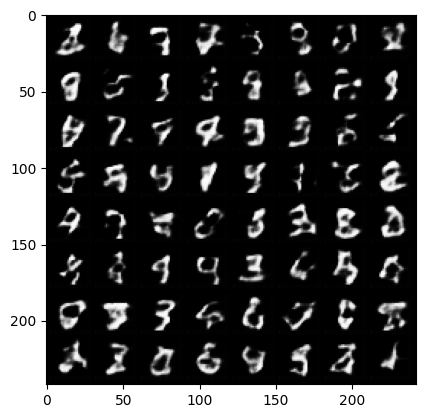

In [10]:
n_epochs = 40
for latent_dim in [20]:
    model_vae = VAE2(latent_dim=latent_dim)
    model_vae = train_vae2(model_vae, train_loader, n_epochs=n_epochs, lr=lr)
    # You can use the following code to visualize generated samples
    model_vae.eval()
    x_hat = model_vae.sample(64,"cpu")
    # x_hat = x_hat.bernoulli()
    show_and_save(make_grid(x_hat.view(64, 1, 28, 28).data.cpu()), f"log/VAE/reference/vae2_fake_{model_vae.latent_dim}")